# پروژه بخش فرایادگیری

ضمن آرزوی توفیق در آخرین پروژه درس شناسایی الگو برای تمامی دانشجویان، پیشنهاد می‌شود پیاده‌سازی پروژه در محیط نوت‌بوک انجام شود. ارائه حضوری پروژه عمده‌ترین بخش از نمره را در بر دارد. به همین دلیل تسلط شما به مفاهیم و سازوکار پیاده‌‌سازیتان تعیین‌کننده خواهد بود.

مقاله‌های رفرنس برای این پروژه

Prototypical Networks (Snell et al., 2017)

Proto-MAML (Triantafillou et al., 2020)

است.

وظیفه‌های نمونه‌محدود کلاس‌بندی در این پروژه مورد استفاده قرار می‌گیرند. مجموعه آموزش و مجموعه آزمون مجموعه‌هایی با کلاس‌های متمایز از هم هستند. به طور مثال مدل برای یک مسأله کلاس‌بندی دودویی، در مرحله آموزش روی تفکیک کلاس‌های سگ-گربه و توپ-گل متمرکز است. اما در مرحله آزمون، مدل برای تفکیک ابر-ساحل مورد ارزیابی قرار می‌گیرد. لازم به‌ذکر است که تعداد نمونه‌های داده در مرحله آزمون محدود است.

برای شروع کار کتاب‌خانه‌های زیر را نصب داشته باشید. روی کگل و گوگل‌لب بیشتر کتابخانه‌ها به صورت پیش‌فرض قرار دارند.




با استفاده از تورچ‌ویژن، دیتاست سی‌فار۱۰۰ اضافه شده است




در نوت‌بوک کگل، سمت راست بالای صفحه روی گزینه سه‌نقطه کلیک کنید و در قسمت

Accelerator

یکی از جی‌پی‌یو‌ها را انتخاب کنید و سپس سل زیر را اجرا کنید.

در گوگل کولب فرآیند

Edit --> Notebook settings --> Hardware accelerator

را طی کنید

In [2]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/content/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/"
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-2-688cd9559864>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cpu


<Figure size 640x480 with 0 Axes>

 در بخش زیر مدل از پیش آموزش‌دیده

ProtoNet

را دانلود کنید. با استفاده از مدل ازپیش آموزش‌دیده در زمان صرفه‌جویی می‌شود
در فاز دوم پروژه نیز به مدل از پیش آموزش‌دیده

ProtoMAMAL

نیاز می‌شود که در همین سلول آن را نیز دانلود می‌کنیم

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = ["ProtoNet.ckpt", "ProtoMAML.ckpt",
                    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
                    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
                    "protomaml_fewshot.json",
                    "protomaml_svhn_fewshot.json"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

# کلاس‌بندی نمونه‌محدود

 در این نوت بوک از

 CIFAR100

  استفاده خواهیم کرد

  CIFAR100

  دارای ۱۰۰ کلاس با ۶۰۰ تصویر در اندازه ۳۲*۳۲ است.

   به جای تقسیم نمونه‌ها به سه مجموعه آموزش، اعتبارسنجی و تست، آنها را به کلاس  افراز می‌کنیم. به این شکل که ۸۰ کلاس برای آموزش، ۱۰ کلاس برای اعتبارسنجی، و ۱۰ کلاس برای تست تخصیص می‌دهیم. هدف کلی ما به دست آوردن مدلی است که بتواند بین ۱۰ کلاس تست با دیدن نمونه‌های بسیار کمی تمایز قائل شود. ابتدا،  مجموعه‌داده را بارگیری می‌کنیم و چند نمونه را نمایش می‌دهیم.
  

In [4]:
# Loading CIFAR100 dataset
CIFAR_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())
CIFAR_val_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 169001437/169001437 [00:05<00:00, 29526266.70it/s]


Extracting /content/cifar-100-python.tar.gz to /content/
Files already downloaded and verified
Files already downloaded and verified


## کامل کنید

  .به صورت رندوم برخی از نمونه‌های دیتاست سی‌فار۱۰۰ را نمایش دهید
  به جای علامت ؟ کد لازم را پیاده‌سازی کنید

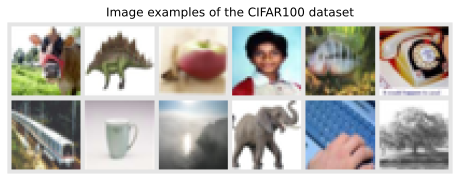

In [6]:
# Visualize some examples
NUM_IMAGES = 12
CIFAR_images = [CIFAR_train_set[i][0] for i in range(NUM_IMAGES)]
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()



#پیش‌پردازش داده‌ها
همان‌طور که بیان شد حال باید سه مجموعه آموزش، اعتبارسنجی و تست را بسازیم.
پکیچ

torchvision

مجموعه آموزش و تست را به صورت دو مجموعه‌داده مجزا به ما می‌دهد. سلول‌های بعدی  مجموعه آموزش و تست را ادغام کرده و سپس تقسیم جدید

 train-val-test

 را ایجاد می کند.

In [7]:
# Merging original training and test set
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

:برای کاهش زمان و مدیریت مجموعه‌داده‌ها کلاس زیر طراحی شده است تا مجموعه‌ای از تصاویر، برچسب‌ها و تبدیل‌های تصویر را می‌گیرد و تصاویر و برچسب‌های متناظرشان را برمی‌گرداند.



کلاس
ImageDataset

Inputs:

       imgs - Numpy array of shape [N,32,32,3] containing all images.
       targets - PyTorch array of shape [N] containing all labels.
       img_transform - A torchvision transformation that should be applied to the
       images before returning. If none, no transformation is applied.[link text](https://)

In [8]:
class ImageDataset(data.Dataset):

    def __init__(self, imgs, targets, img_transform=None):
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

اکنون می‌توانیم تقسیم کلاس‌ها را ایجاد کنیم. کلاس‌ها را به‌طور تصادفی به آموزش، اعتبارسنجی و آزمایش اختصاص می‌دهیم و از تقسیم 80%-10%-10% استفاده می‌کنیم.

## کامل کنید

ابتدا جایگشتی رندوم از صفر تا ۹۹ را در متغیر

 classes

بریزید و سپس به کمک مفهوم

 slice

 در پایتون، هشتاد کلاس اول را به مجموعه کلاس‌های آموزش، ده‌تای بعدی را به مجموعه کلاس‌های اعتبارسنجی و مابقی را به مجموعه کلاس‌های آزمون اختصاص دهید.

  به جای علامت ؟ کد لازم را پیاده‌سازی کنید

In [9]:
import torch

torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99

# Assign the first 80 classes to the training set, the next 10 to the validation set, and the rest to the test set
train_classes = classes[:80]
val_classes = classes[80:90]
test_classes = classes[90:]


حال نام کلاس‌های اعتبارسنجی و آزمون که تفکیک کردید را در سل زیر چاپ کنید.




In [10]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


### توضیح دهید
رفتار تابع زیر را توضیح دهید

In [11]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    if isinstance(imgs, str):  # If imgs is a file path
        img_dataset = torchvision.datasets.ImageFolder(root=imgs, transform=kwargs.get('img_transform'))
        class_mask = torch.tensor([img_dataset.class_to_idx[str(c)] for c in class_set])
    else:
        imgs = torch.tensor(imgs) if not torch.is_tensor(imgs) else imgs
        class_mask = torch.any(targets[:, None] == class_set[None, :], dim=-1)

    return ImageDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)


### کامل کنید
به کمک تابع

dataset_from_labels

بخش ؟؟؟ کد را پر کنید

### توضیح دهید
در قطعه کد زیر برای جلوگیری از بیش‌برازش

overfitting

از چه تکنیک‌های استفاده کرده است؟

In [12]:
# Define your dataset paths or variables
train_imgs, train_targets = dataset_from_labels('/content/cifar-100-python/train', train_classes, class_set=train_classes, img_transform=train_transform)
val_imgs, val_targets = dataset_from_labels('/content/cifar-100-python/meta', val_classes, class_set=val_classes, img_transform=test_transform)
test_imgs, test_targets = dataset_from_labels('/content/cifar-100-python/test', test_classes, class_set=test_classes, img_transform=test_transform)

# Define the class set for each dataset split
train_classes = set(train_classes)  # Assuming train_classes is previously defined
val_classes = set(val_classes)      # Assuming val_classes is previously defined
test_classes = set(test_classes)    # Assuming test_classes is previously defined

# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975, 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, add some augmentation to prevent overfitting
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                      ])

# Create datasets using the dataset_from_labels function
train_set = dataset_from_labels(train_imgs, train_targets, train_classes, class_set=train_classes, img_transform=train_transform)
val_set = dataset_from_labels(val_imgs, val_targets, val_classes, class_set=val_classes, img_transform=test_transform)
test_set = dataset_from_labels(test_imgs, test_targets, test_classes, class_set=test_classes, img_transform=test_transform)


NameError: name 'train_transform' is not defined

# نمونه‌گیری داده‌ها
استراتژی استفاده از داده‌های آموزش موجود برای یادگیری نمونه‌محدود در فرایادگیری بسیار مهم است. شبیه‌سازی یادگیری نمونه‌محدود در حین آموزش، در هر مرحله، تعداد کمی از کلاس‌ها را به صورت تصادفی انتخاب می‌کنیم و تعداد کمی نمونه برای هر کلاس نمونه‌برداری می‌‌کنیم.

### توضیح دهید

در تابع

__initi__

در کلاس

FewShotBatchSampler

دو آرگومان ورودی

 K_shotو N_way

 هر کدام بیان‌گر چه چیزی هستند؟

        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - ???????????
            K_shot - ??????????
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """

In [ ]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [ ]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=4)

In [ ]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

### کامل کنید
به کمک تابع

split_batch

دو مجموعه

support_imags, query_imgs

را بسازید. تا خروجی مورد نظر نمایش داده شود.

جای ???? را با کد پیاده‌‌‌سازی پر کنید

In [ ]:
imgs, targets = next(iter(val_data_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = ??????
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

# Prototypical Networks
یک رویکرد در فرایادگیری بانظارت رویکرد ناپارامتری است. شبکه‌

Prototypical

است. در مرحله متاتست رویکرد ناپارامتری تنها وجود دارد و در مرحله فراآموزش همچنان رویکرد پارامتریک دنبال می‌شود. در روش‌های ناپارامتری با داشتن داده‌های آموزش یک وظیفه هنگامی که داده تست به مدل وارد می‌شود؛ فاصله آن با تک تک نمونه‌ها اندازه‌گیری می‌شود. سپس بر اساس این‌که به داده جدید به کدام نمونه نزدیک‌تر است برچسب همان نمونه را به خود اختصاص می‌دهد که همان روش مرسوم کا-نزدیک‌ترین همسایه است. هدف تدارک فضایی است که فاصله اقلیدسی بین نمونه‌ها معنادار و مورد انتظار انسان شود.

پیدا می‌کند. هنگامی که نمونه‌های یک وظیفه جدید ورودی داده شوند، شبکه فاصله داده جدید را با تک‌تک نمونه‌های آموزش آن وظیفه اندازه می‌گیرد و از این طریق برچسب داده جدید را مشخص می‌کند.

در شبکه‌های

Prototypical

 نمونه‌های یک دسته مستقل از هم دیده نمی‌شوند

 برای اطلاعات بیشتر به مقاله رفرنس رجوع کنید


اکنون که می‌دانیم اصولاً یک

ProtoNet

چگونه کار می‌کند، آن را برای مساله کلاس‌بندی تصاویر اعمال می‌کنیم. ابتدا باید تابع رمزگذار را تعریف کنیم

In [ ]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size  # Output dimensionality
                                         )
    return convnet

اولین گام در طول آموزش این است که تمام تصاویر را به صورت پیمانه‌ای با شبکه  رمزگذاری کنیم. در مرحله بعد، از روی ساپورت‌ست کلاس

prototypes


نمونه‌های اولیه کلاس را از مجموعه پشتیبانی محاسبه می‌کنیم

calculate_prototypes()

و نمونه‌های کوئری‌ست را با

classify_feats

کلاس‌بندی می‌کنیم

        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """

In [ ]:
class ProtoNet(pl.LightningModule):

    def __init__(self, proto_dim, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

#آموزش
پس از پیاده‌سازی مدل، می‌توانیم آموزش آن را شروع کنیم. از تابع آموزشی

PyTorch Lightning

  استفاده می کنیم و مدل را برای ۲۰۰ ایپاک آموزش می‌دهیم.

In [ ]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

In [ ]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

### سل زیر را اجرا کنید و در داشبورد تنسوربرد نمودارهای

### train_acc, train_loss, val_acc, val_loss

### را تحلیل کنید و ارتباط آن‌ها با یکدیگر و تاثیر تعداد ایپاک و نرخ یادگیری را  بر آن‌ها توضیح دهید

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
%tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoNet

## ارزیابی

In [ ]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=4, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

## خروجی سل زیر را ذخیره کنید و تلاش کنید با تغییر هایپرپارامترهای فرآیند یادگیری، دقت را افزایش دهید و با خروجی قبل مقایسه کنید. اگر موفق به بهبود دقت مدل نشدید حدس خود را در این مورد بنویسید.

k

را دستکاری نکنید

In [ ]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

In [ ]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

**نمودار زیر را تحلیل کنید**

In [ ]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

# ProtoMAML

        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of the outer loop Adam optimizer
            lr_inner - Learning rate of the inner loop SGD optimizer
            lr_output - Learning rate for the output layer in the inner loop
            num_inner_steps - Number of inner loop updates to perform
        """




## پیاده‌سازی

در کلاس

ProtoMAML

در تابع

adapt_few_shot()

در جای مشخص شده، لوپ داخلی مدل و بهینه‌ساز آن را پیاده‌‌سازی کنید

In [ ]:
class ProtoMAML(pl.LightningModule):

    def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140,180], gamma=0.1)
        return [optimizer], [scheduler]

    def run_model(self, local_model, output_weight, output_bias, imgs, labels):
        # Execute a model with given output layer weights and inputs
        feats = local_model(imgs)
        preds = F.linear(feats, output_weight, output_bias)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc

    def adapt_few_shot(self, support_imgs, support_targets):
        # Determine prototype initialization
        support_feats = self.model(support_imgs)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        support_labels = (classes[None,:] == support_targets[:,None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        #*******************************
        #*******************************
        #*******************************
        #*******************************
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1)**2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()

        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            # (https://discuss.pytorch.org/t/the-difference-between-torch-tensor-data-and-torch-tensor/25995/4):
            with torch.no_grad():
                output_weight.copy_(output_weight - self.hparams.lr_output * output_weight.grad)
                output_bias.copy_(output_bias - self.hparams.lr_output * output_bias.grad)

            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)

        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias

        return local_model, output_weight, output_bias, classes

    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()

        # Determine gradients for batch of tasks
        for task_batch in batch:
            imgs, targets = task_batch
            support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
            # Perform inner loop adaptation
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
            # Determine loss of query set
            query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model

            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())

        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()

        self.log(f"{mode}_loss", sum(losses) / len(losses))
        self.log(f"{mode}_acc", sum(accuracies) / len(accuracies))

    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning

    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

## آموزش
## ProtoMAML

برای آموزش

 ProtoMAML

  باید نمونه‌برداری خود را نسبت به روش قبل تغییر دهیم. به جای یک
  
  batch

  از مجموعه ساپورت-کوئری، باید چندین
  
  batch

  .نمونه‌برداری کنیم

        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """

In [ ]:
class TaskBatchSampler(object):

    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size

    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx+1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []

    def __len__(self):
        return len(self.batch_sampler)//self.task_batch_size

    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            imgs = torch.stack([img for img, target in item_list], dim=0)
            targets = torch.stack([target for img, target in item_list], dim=0)
            imgs = imgs.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(imgs, targets))
        return collate_fn

In [ ]:
# Training constant (same as for ProtoNet)
N_WAY = 5
K_SHOT = 4

# Training set
train_protomaml_sampler = TaskBatchSampler(train_set.targets,
                                           include_query=True,
                                           N_way=N_WAY,
                                           K_shot=K_SHOT,
                                           batch_size=16)
train_protomaml_loader = data.DataLoader(train_set,
                                         batch_sampler=train_protomaml_sampler,
                                         collate_fn=train_protomaml_sampler.get_collate_fn(),
                                         num_workers=2)

# Validation set
val_protomaml_sampler = TaskBatchSampler(val_set.targets,
                                         include_query=True,
                                         N_way=N_WAY,
                                         K_shot=K_SHOT,
                                         batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
                                         shuffle=False)
val_protomaml_loader = data.DataLoader(val_set,
                                       batch_sampler=val_protomaml_sampler,
                                       collate_fn=val_protomaml_sampler.get_collate_fn(),
                                       num_workers=2)

## توضیح دهید

حال می‌تون مدل را آموزش دهیم. از همان اندازه فضای ویژگی برای

ProtoNet

استفاده می‌شود، اما می‌توان از نرخ یادگیری بالاتری نسبت به لوپ خارجی استفاده کرد.
به نظر شما چرا؟


In [ ]:
protomaml_model = train_model(ProtoMAML,
                              proto_dim=64,
                              lr=1e-3,
                              lr_inner=0.1,
                              lr_output=0.1,
                              num_inner_steps=1,  # Often values between 1 and 10
                              train_loader=train_protomaml_loader,
                              val_loader=val_protomaml_loader)

## تحلیل کنید

**تنسوربورد زیر را تحلیل کنید**
و با

**ProtoNet**

مقایسه کنید

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
%tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoMAML/

## ارزیابی

In [ ]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes

    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset,
                                      batch_size=128,
                                      num_workers=4,
                                      shuffle=False,
                                      drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(dataset.targets,
                                  include_query=False,
                                  N_way=num_classes,
                                  K_shot=k_shot,
                                  shuffle=False,
                                  shuffle_once=False)
    sample_dataloader = data.DataLoader(dataset,
                                        batch_sampler=sampler,
                                        num_workers=2)

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(zip(sample_dataloader, sampler), "Performing few-shot finetuning"):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        # Finetune new model on support set
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)
        with torch.no_grad():  # No gradients for query set needed
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            # Evaluate all examples in test dataset
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            # Exclude support set elements
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
    return mean(accuracies), stdev(accuracies)

در مقایسه با مرحله آموزش، توصیه می‌شود در طول تست از به‌روزرسانی حلقه داخلی استفاده شود. در طول آموزش، ما قصدی برای دریافت بهترین مدل از حلقه داخلی نداریم، بلکه به مدلی علاقه‌مندیم که بتوان بهترین گرادیان‌ها را ارائه دهد. از این رو، ممکن است یک به‌روز‌رسانی در حال حاضر در آموزش کافی باشد، اما برای تست، اغلب مشاهده شده است که تعداد بیشتری از به‌روز‌رسانی‌ها می‌توانند عملکرد مدل را به صورت قابل توجهی افزایش دهند. بنابراین، قبل از تست، به‌روز‌رسانی حلقه داخلی را به 200 تغییر می‌دهیم.

In [ ]:
protomaml_model.hparams.num_inner_steps = 200

اکنون می‌توان مدل خود را تست کنیم. برای مدل های از قبل آموزش دیده، یک فایل

json

با نتایج ارائه شده است تا زمان ارزیابی کاهش یابد.

In [ ]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file, 'r') as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    protomaml_accuracies = dict()
    for k in [2, 4, 8, 16, 32]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, 'w') as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(f"Accuracy for k={k}: {100.0*protomaml_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_accuracies[k][1]:4.2f}%)")

## تحلیل کنید

نمودار زیر را تحلیل کنید

In [ ]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()

# سوال امتیازی
#### همین روند را با یکی از مدل‌های
#### MAML or Reptile
#### پیاده‌سازی کنید